resources:
https://distill.pub/2019/visual-exploration-gaussian-processes/
https://ndcbe.github.io/cbe67701-uncertainty-quantification/10.03-Gaussian-Process-Regression.html
https://domino.ai/blog/fitting-gaussian-process-models-python

In [1]:
from utils import *
from map_utils import *
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel
import pickle
from sklearn.metrics import mean_squared_error
import numpy as np
import seaborn as sns

# map

In [2]:
region = 'germany'
points, polygon, map_boundary = get_points_in_region(points, region)
X, Y = get_map_grid(polygon, map_boundary, 10)
grid = np.array((Y, X)).T

NameError: name 'points' is not defined

In [ ]:
map = np.empty((0, X.shape[0]))

for vertical_line in tqdm(grid):
    pred, stdv = gp.predict(vertical_line, return_std=True)
    map = np.vstack((map, pred))
    

100%|██████████| 100/100 [00:26<00:00,  3.72it/s]


In [ ]:
map = map.T

In [ ]:
np.savetxt(f'intermediate/map_gp_{region}.txt', map)

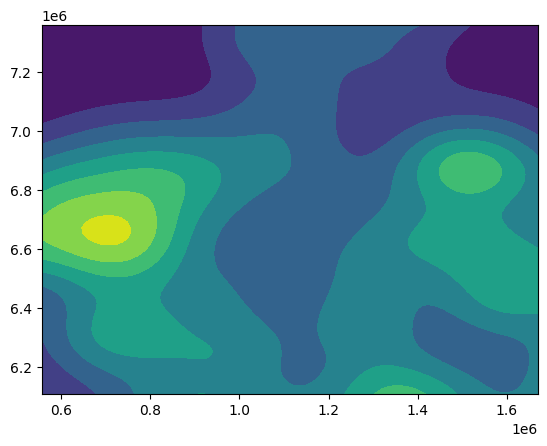

In [ ]:
# preview
p = plt.contourf(X, Y, map)
plt.show()

In [ ]:
stop

NameError: name 'stop' is not defined

# 1D

In [19]:
points = get_points('../data/artificial_points_gp.csv')
points['lat'] = points.geometry.y
points['lon'] = points.geometry.x

X = points[['lat', 'lon']].values
y = points['wait'].values

# assuming mean = 0 in the gp setup
average = np.mean(y)
y = y - average

In [20]:
# TODO: set baseline that is approached when there is no data -> mean of all points?
# TODO: find hyperparameters that minimize a metric that favors smooth curves
# TODO: why wouldnt this give the smallest possible length scale? regularization?

# larger rbf sigma (stdv) to allow deviation from 0 (mean) -> factor before rbf kernel via constant kernel -> sigma
# larger rbf length for more smoothness -> length scale of rbf kernel -> l

# error (noise) stdv added to diagonal of kernel matrix as parameter -> alpha

# parameters to optimize
sigma = 1.0
l = [1.0, 1.0] # lat and lon dimensions
alpha = 1e-10

rbf = RBF(
    length_scale=l, length_scale_bounds=(1e-05, 100000.0)
)  # using anisotripic kernel (different length scales for each dimension)
kernel = ConstantKernel(constant_value=sigma, constant_value_bounds=(1e-2, 1e2)) * rbf

gp = GaussianProcessRegressor(
    kernel=kernel,
    alpha=alpha**2,
    optimizer="fmin_l_bfgs_b", # maximizing marginal log lik: given the data, how likely is the parameterization of the kernel
    # (if we draw a sample frome the multivariate gaussian with the kernel as covariance matrix, how likely is the data we have seen)
    # prevents overfitting to some degree
    normalize_y=False,
    n_restarts_optimizer=100,
    random_state=42,
)

In [21]:
gp.fit(X, y)

/home/till/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/till/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(kernel=1**2 * RBF(length_scale=[1, 1]),
                         n_restarts_optimizer=100, random_state=42)

In [22]:
x_test = np.linspace(start=1000000, stop=2600000, num=300)
x_test = np.array([[0, xi] for xi in x_test])

In [23]:
y_pred, sigma = gp.predict(x_test, return_std=True)
y_pred = y_pred + average # add back the mean

<Axes: >

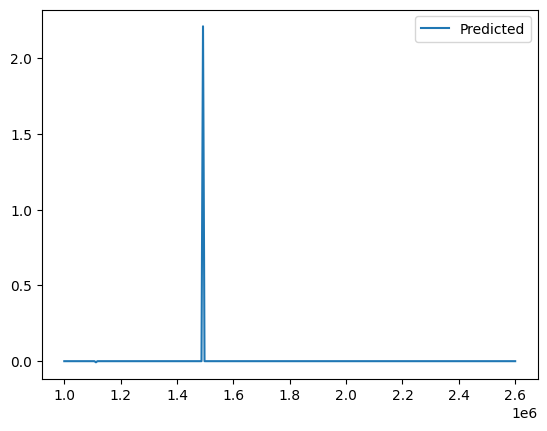

In [24]:
sns.lineplot(x=x_test[:, 1], y=y_pred, label='Predicted')

In [ ]:
# plt.errorbar(x_pred, y_pred, yerr=sigmas, capsize=0)
# plt.plot(x, y, "ro")

In [ ]:


# Root mean squared error ... for eval

In [25]:
stop

NameError: name 'stop' is not defined

# 2D using location

In [ ]:
points = get_points('../data/points_train.csv')
points['lat'] = points.geometry.y
points['lon'] = points.geometry.x

X = points[['lat', 'lon']].values
y = points['wait'].values

In [ ]:
rbf = RBF([1.0, 1.0], length_scale_bounds=(1e-05, 100000.0)) # using anisotripic kernel
gp = GaussianProcessRegressor(kernel=rbf, alpha=5.0**2, n_restarts_optimizer=10, random_state=42)

In [ ]:
gp.fit(X, y)

/home/till/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 0 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/till/miniconda3/envs/heatchmap/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:455: ConvergenceWarning: The optimal value found for dimension 1 of parameter length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


GaussianProcessRegressor(alpha=900.0, kernel=RBF(length_scale=[1, 1]),
                         n_restarts_optimizer=10, random_state=42)

In [ ]:
with open('models/gp_model.pkl', 'wb') as f:
    pickle.dump(gp, f)

In [ ]:
points['pred'], points['std'] = gp.predict(X, return_std=True)
mean_squared_error(points['wait'], points['pred'])

6153.818056183918

In [ ]:
gp = pickle.load(open('models/gp_model.pkl', 'rb'))

In [ ]:
# validation
val = get_points('../data/points_val.csv')
val['lat'] = val.geometry.y
val['lon'] = val.geometry.x

X = val[['lat', 'lon']].values

In [ ]:
val['pred'], val['std'] = gp.predict(X, return_std=True)
mean_squared_error(val['wait'], val['pred'])

5458.617323673392

In [ ]:
val.pred.value_counts()


pred
2.018799    1
2.208470    1
3.156443    1
2.120483    1
3.149932    1
           ..
2.178737    1
0.913587    1
0.438099    1
1.705279    1
0.100004    1
Name: count, Length: 3286, dtype: int64

# 3D using location and time when the spot was recorded (might use single ratings of spots here instead averaged)